# Data Preperation for Kaggle dataset masks through the use of SAM
---

# Mount Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# This section defines the directory mapping
- **IMPORTATNT NOTE:** If your data is in a different directory structure update it in `dir_map`
---

In [ ]:
import os

dir_map = {
    'KAGGLE_IMAGES_DIR':'/content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/images',
    'KAGGLE_MASKS_OUTPUT_DIR':'/content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks',
}

# Used Primarily for Output Directory (Preferably not made yet), Raw Images folders need to have images to process
for _, path in dir_map.items():
    dir = os.getcwd() + '/' + path
    if not os.path.exists(dir):
        os.makedirs(dir)
        print(f'Directory "{str(dir)}" created')
    else:
        print(f'Directory "{str(dir)}" already exists')

Directory "/content//content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/images" already exists
Directory "/content//content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks" already exists


# This section sets the enviorment to use SAM to generate the masks
---
- **IMPORTANT NOTE: **
  - Install torch if not already. Do not run if already installed.
  - `!pip install torch torchvision`


In [ ]:
!pip install opencv-python matplotlib
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-cgmbxj3y
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-cgmbxj3y
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


# Import dependencies


In [ ]:
# Tested on python 3.9.16
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

import torch
import cv2

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import requests
import os
from skimage import io, color
from natsort import natsorted

PyTorch version: 2.1.0+cu118
Torchvision version: 0.16.0+cu118
CUDA is available: True


# Download pretrained model

In [ ]:
# URL of the pretrained model
url = 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

# Local path to save the downloaded model
file_path = 'sam_vit_h_4b8939.pth'

# Download the file from the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Open the file in write-binary mode and save the content
    with open(file_path, 'wb') as file:
        file.write(response.content)
    print(f"Model downloaded successfully and saved as {file_path}")
else:
    print("Failed to download the model")

Model downloaded successfully and saved as sam_vit_h_4b8939.pth


# Set downloaded model configs

In [ ]:
sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

# Define the function used to create the mask for the image

In [ ]:
'''
  Notes:
  Here are the description of the parameters
  #https://github.com/facebookresearch/segment-anything/blob/9e1eb9fdbc4bca4cd0d948b8ae7fe505d9f4ebc7/segment_anything/automatic_mask_generator.py#L35
'''

def generate_mask(img):
  mask_generator_ = SamAutomaticMaskGenerator(
      model=sam,
      points_per_side=64,
      pred_iou_thresh=0.94,
      stability_score_thresh=0.95,
      crop_n_layers=1,
      crop_n_points_downscale_factor=2,
      min_mask_region_area=100,  # Requires open-cv to run post-processing
      output_mode='binary_mask',
  )
  masks = mask_generator_.generate(img)
  return masks

# Define function to show annotations

In [ ]:
def show_anns(anns):
  if len(anns) == 0:
    return
  sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
  ax = plt.gca()
  ax.set_autoscale_on(False)
  polygons = []
  color = []
  for ann in sorted_anns:
    m = ann['segmentation']
    img = np.ones((m.shape[0], m.shape[1], 3))
    color_mask = np.random.random((1, 3)).tolist()[0]
    for i in range(3):
        img[:,:,i] = color_mask[i]
    ax.imshow(np.dstack((img, m*0.35)))

# Create Masks for all Kaggle images
NOTE:
- This will overwrite the images present in your 'KAGGLE_MASKS_OUTPUT_DIR' whatever that may be
- This is the most computationaly intensive cell
- Requires GPU for CUDA pytorch

In [ ]:
"""
Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

segmentation : the mask
area : the area of the mask in pixels
bbox : the boundary box of the mask in XYWH format
predicted_iou : the model's own prediction for the quality of the mask
point_coords : the sampled input point that generated this mask
stability_score : an additional measure of mask quality
crop_box : the crop of the image used to generate this mask in XYWH format
output_mode (str): The form masks are returned in. Can be 'binary_mask',

"""
# Process all images in KAGGLE_image_paths
KAGGLE_image_paths = natsorted(glob(dir_map['KAGGLE_IMAGES_DIR'] + '/*.tif'))

for idx, img_path in enumerate(KAGGLE_image_paths):
  # Load the current image
  KAGGLE_original_img = io.imread(img_path)

  # Convert grayscale image to RGB
  KAGGLE_original_img = color.gray2rgb(KAGGLE_original_img)

  # Generate masks for the current image
  masks = generate_mask(KAGGLE_original_img)

  # Create an empty combined mask for the current image
  combined_mask = np.zeros_like(masks[0]['segmentation'], dtype=np.uint8)

  # Combine individual masks into the combined mask for the current image
  for mask_dict in masks:
    combined_mask += (mask_dict['segmentation'] * 255).astype(np.uint8)

    # Check and convert data type and range
    if combined_mask.dtype != np.uint8:
        combined_mask = combined_mask.astype(np.uint8)

    if combined_mask.max() > 255 or combined_mask.min() < 0:
        # Normalize
        combined_mask = np.clip(combined_mask, 0, 255)

  # Define the filename for the current mask, incrementing the index
  custom_name = f"kaggle_mask{idx+1}.tif"

  # Specify the save path for the current mask
  save_path = os.path.join(dir_map['KAGGLE_MASKS_OUTPUT_DIR'], custom_name)

  # Save the combined mask to a file
  io.imsave(save_path, combined_mask)

  # Print a message indicating that the masks for the current image have been processed and saved
  print(f"Kaggle mask -> {custom_name} has been processed and saved ")

Kaggle mask -> kaggle_mask1.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask2.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask2.tif has been processed and saved 
Kaggle mask -> kaggle_mask3.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask4.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask4.tif has been processed and saved 
Kaggle mask -> kaggle_mask5.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask6.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask6.tif has been processed and saved 
Kaggle mask -> kaggle_mask7.tif has been processed and saved 
Kaggle mask -> kaggle_mask8.tif has been processed and saved 
Kaggle mask -> kaggle_mask9.tif has been processed and saved 
Kaggle mask -> kaggle_mask10.tif has been processed and saved 
Kaggle mask -> kaggle_mask11.tif has been processed and saved 
Kaggle mask -> kaggle_mask12.tif has been processed and saved 
Kaggle mask -> kaggle_mask13.tif has been processed and saved 
Kaggle mask -> kaggle_mask14.tif has been processed and saved 
Kaggle mask -> kaggle_mask15.tif has been processed and saved 
Kaggle mask -> kaggle_mask16.tif has been processed and saved 
Kaggle mask -> kaggle_mask17.tif has been processed and saved 
Kaggle mask -> kaggle_mask18.tif has been processed and saved 
Kaggle mask -> kaggle_mask19.tif has been processed and saved 
Kaggle mask -> kaggle_mask20.tif has been processed and saved 
Kaggle mask -> kaggle_mask21.tif has been processed and sav

<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask24.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask24.tif has been processed and saved 
Kaggle mask -> kaggle_mask25.tif has been processed and saved 
Kaggle mask -> kaggle_mask26.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask27.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask27.tif has been processed and saved 
Kaggle mask -> kaggle_mask28.tif has been processed and saved 
Kaggle mask -> kaggle_mask29.tif has been processed and saved 
Kaggle mask -> kaggle_mask30.tif has been processed and saved 
Kaggle mask -> kaggle_mask31.tif has been processed and saved 
Kaggle mask -> kaggle_mask32.tif has been processed and saved 
Kaggle mask -> kaggle_mask33.tif has been processed and saved 
Kaggle mask -> kaggle_mask34.tif has been processed and saved 
Kaggle mask -> kaggle_mask35.tif has been processed and saved 
Kaggle mask -> kaggle_mask36.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask37.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask37.tif has been processed and saved 
Kaggle mask -> kaggle_mask38.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask39.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask39.tif has been processed and saved 
Kaggle mask -> kaggle_mask40.tif has been processed and saved 
Kaggle mask -> kaggle_mask41.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask42.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask42.tif has been processed and saved 
Kaggle mask -> kaggle_mask43.tif has been processed and saved 
Kaggle mask -> kaggle_mask44.tif has been processed and saved 
Kaggle mask -> kaggle_mask45.tif has been processed and saved 
Kaggle mask -> kaggle_mask46.tif has been processed and saved 
Kaggle mask -> kaggle_mask47.tif has been processed and saved 
Kaggle mask -> kaggle_mask48.tif has been processed and saved 
Kaggle mask -> kaggle_mask49.tif has been processed and saved 
Kaggle mask -> kaggle_mask50.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask51.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask51.tif has been processed and saved 
Kaggle mask -> kaggle_mask52.tif has been processed and saved 
Kaggle mask -> kaggle_mask53.tif has been processed and saved 
Kaggle mask -> kaggle_mask54.tif has been processed and saved 
Kaggle mask -> kaggle_mask55.tif has been processed and saved 
Kaggle mask -> kaggle_mask56.tif has been processed and saved 
Kaggle mask -> kaggle_mask57.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask58.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask58.tif has been processed and saved 
Kaggle mask -> kaggle_mask59.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask60.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask60.tif has been processed and saved 
Kaggle mask -> kaggle_mask61.tif has been processed and saved 
Kaggle mask -> kaggle_mask62.tif has been processed and saved 
Kaggle mask -> kaggle_mask63.tif has been processed and saved 
Kaggle mask -> kaggle_mask64.tif has been processed and saved 
Kaggle mask -> kaggle_mask65.tif has been processed and saved 
Kaggle mask -> kaggle_mask66.tif has been processed and saved 
Kaggle mask -> kaggle_mask67.tif has been processed and saved 
Kaggle mask -> kaggle_mask68.tif has been processed and saved 
Kaggle mask -> kaggle_mask69.tif has been processed and saved 
Kaggle mask -> kaggle_mask70.tif has been processed and saved 
Kaggle mask -> kaggle_mask71.tif has been processed and saved 
Kaggle mask -> kaggle_mask72.tif has been processed and saved 
Kaggle mask -> kaggle_mask73.tif has been processed and saved 
Kaggle mask -> kaggle_mask74.tif has been processed and saved 
Kaggle mask -> kaggle_mask75.tif has been processed and

<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask92.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask92.tif has been processed and saved 
Kaggle mask -> kaggle_mask93.tif has been processed and saved 
Kaggle mask -> kaggle_mask94.tif has been processed and saved 
Kaggle mask -> kaggle_mask95.tif has been processed and saved 
Kaggle mask -> kaggle_mask96.tif has been processed and saved 
Kaggle mask -> kaggle_mask97.tif has been processed and saved 
Kaggle mask -> kaggle_mask98.tif has been processed and saved 
Kaggle mask -> kaggle_mask99.tif has been processed and saved 
Kaggle mask -> kaggle_mask100.tif has been processed and saved 
Kaggle mask -> kaggle_mask101.tif has been processed and saved 
Kaggle mask -> kaggle_mask102.tif has been processed and saved 
Kaggle mask -> kaggle_mask103.tif has been processed and saved 
Kaggle mask -> kaggle_mask104.tif has been processed and saved 
Kaggle mask -> kaggle_mask105.tif has been processed and saved 
Kaggle mask -> kaggle_mask106.tif has been processed and saved 
Kaggle mask -> kaggle_mask107.tif has been proce

<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask138.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask138.tif has been processed and saved 
Kaggle mask -> kaggle_mask139.tif has been processed and saved 
Kaggle mask -> kaggle_mask140.tif has been processed and saved 
Kaggle mask -> kaggle_mask141.tif has been processed and saved 
Kaggle mask -> kaggle_mask142.tif has been processed and saved 
Kaggle mask -> kaggle_mask143.tif has been processed and saved 
Kaggle mask -> kaggle_mask144.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask145.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask145.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask146.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask146.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask147.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask147.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask148.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask148.tif has been processed and saved 
Kaggle mask -> kaggle_mask149.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask150.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask150.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask151.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask151.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask152.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask152.tif has been processed and saved 
Kaggle mask -> kaggle_mask153.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask154.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask154.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask155.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask155.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask156.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask156.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask157.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask157.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask158.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask158.tif has been processed and saved 
Kaggle mask -> kaggle_mask159.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask160.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask160.tif has been processed and saved 
Kaggle mask -> kaggle_mask161.tif has been processed and saved 
Kaggle mask -> kaggle_mask162.tif has been processed and saved 
Kaggle mask -> kaggle_mask163.tif has been processed and saved 
Kaggle mask -> kaggle_mask164.tif has been processed and saved 
Kaggle mask -> kaggle_mask165.tif has been processed and saved 
Kaggle mask -> kaggle_mask166.tif has been processed and saved 
Kaggle mask -> kaggle_mask167.tif has been processed and saved 
Kaggle mask -> kaggle_mask168.tif has been processed and saved 
Kaggle mask -> kaggle_mask169.tif has been processed and saved 
Kaggle mask -> kaggle_mask170.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask171.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask171.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask172.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask172.tif has been processed and saved 
Kaggle mask -> kaggle_mask173.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask174.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask174.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask175.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask175.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask176.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask176.tif has been processed and saved 
Kaggle mask -> kaggle_mask177.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask178.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask178.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask179.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask179.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask180.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask180.tif has been processed and saved 
Kaggle mask -> kaggle_mask181.tif has been processed and saved 
Kaggle mask -> kaggle_mask182.tif has been processed and saved 
Kaggle mask -> kaggle_mask183.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask184.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask184.tif has been processed and saved 
Kaggle mask -> kaggle_mask185.tif has been processed and saved 
Kaggle mask -> kaggle_mask186.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask187.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask187.tif has been processed and saved 
Kaggle mask -> kaggle_mask188.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask189.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask189.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask190.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask190.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask191.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask191.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask192.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask192.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask193.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask193.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask194.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask194.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask195.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask195.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask196.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask196.tif has been processed and saved 
Kaggle mask -> kaggle_mask197.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask198.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask198.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask199.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask199.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask200.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask200.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask201.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask201.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask202.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask202.tif has been processed and saved 
Kaggle mask -> kaggle_mask203.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask204.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask204.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask205.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask205.tif has been processed and saved 
Kaggle mask -> kaggle_mask206.tif has been processed and saved 
Kaggle mask -> kaggle_mask207.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask208.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask208.tif has been processed and saved 
Kaggle mask -> kaggle_mask209.tif has been processed and saved 
Kaggle mask -> kaggle_mask210.tif has been processed and saved 
Kaggle mask -> kaggle_mask211.tif has been processed and saved 
Kaggle mask -> kaggle_mask212.tif has been processed and saved 
Kaggle mask -> kaggle_mask213.tif has been processed and saved 
Kaggle mask -> kaggle_mask214.tif has been processed and saved 
Kaggle mask -> kaggle_mask215.tif has been processed and saved 
Kaggle mask -> kaggle_mask216.tif has been processed and saved 
Kaggle mask -> kaggle_mask217.tif has been processed and saved 
Kaggle mask -> kaggle_mask218.tif has been processed and saved 
Kaggle mask -> kaggle_mask219.tif has been processed and saved 
Kaggle mask -> kaggle_mask220.tif has been processed and saved 
Kaggle mask -> kaggle_mask221.tif has been processed and saved 
Kaggle mask -> kaggle_mask222.tif has been processed and saved 
Kaggle mask -> kaggle_mask223.tif has be

<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask273.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask273.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask274.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask274.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask275.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask275.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask276.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask276.tif has been processed and saved 
Kaggle mask -> kaggle_mask277.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask278.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask278.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask279.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask279.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask280.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask280.tif has been processed and saved 
Kaggle mask -> kaggle_mask281.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask282.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask282.tif has been processed and saved 
Kaggle mask -> kaggle_mask283.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask284.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask284.tif has been processed and saved 
Kaggle mask -> kaggle_mask285.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask286.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask286.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask287.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask287.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask288.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask288.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask289.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask289.tif has been processed and saved 
Kaggle mask -> kaggle_mask290.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask291.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask291.tif has been processed and saved 
Kaggle mask -> kaggle_mask292.tif has been processed and saved 
Kaggle mask -> kaggle_mask293.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask294.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask294.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask295.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask295.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask296.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask296.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask297.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask297.tif has been processed and saved 
Kaggle mask -> kaggle_mask298.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask299.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask299.tif has been processed and saved 
Kaggle mask -> kaggle_mask300.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask301.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask301.tif has been processed and saved 
Kaggle mask -> kaggle_mask302.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask303.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask303.tif has been processed and saved 
Kaggle mask -> kaggle_mask304.tif has been processed and saved 
Kaggle mask -> kaggle_mask305.tif has been processed and saved 
Kaggle mask -> kaggle_mask306.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask307.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask307.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask308.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask308.tif has been processed and saved 
Kaggle mask -> kaggle_mask309.tif has been processed and saved 
Kaggle mask -> kaggle_mask310.tif has been processed and saved 
Kaggle mask -> kaggle_mask311.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask312.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask312.tif has been processed and saved 
Kaggle mask -> kaggle_mask313.tif has been processed and saved 
Kaggle mask -> kaggle_mask314.tif has been processed and saved 
Kaggle mask -> kaggle_mask315.tif has been processed and saved 
Kaggle mask -> kaggle_mask316.tif has been processed and saved 
Kaggle mask -> kaggle_mask317.tif has been processed and saved 
Kaggle mask -> kaggle_mask318.tif has been processed and saved 
Kaggle mask -> kaggle_mask319.tif has been processed and saved 
Kaggle mask -> kaggle_mask320.tif has been processed and saved 
Kaggle mask -> kaggle_mask321.tif has been processed and saved 
Kaggle mask -> kaggle_mask322.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask323.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask323.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask324.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask324.tif has been processed and saved 
Kaggle mask -> kaggle_mask325.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask326.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask326.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask327.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask327.tif has been processed and saved 
Kaggle mask -> kaggle_mask328.tif has been processed and saved 
Kaggle mask -> kaggle_mask329.tif has been processed and saved 
Kaggle mask -> kaggle_mask330.tif has been processed and saved 
Kaggle mask -> kaggle_mask331.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask332.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask332.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask333.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask333.tif has been processed and saved 


<ipython-input-27-65989892f638>:49: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks/kaggle_mask334.tif is a low contrast image
  io.imsave(save_path, combined_mask)


Kaggle mask -> kaggle_mask334.tif has been processed and saved 
Kaggle mask -> kaggle_mask335.tif has been processed and saved 


# Plot image and call show_anns to display annotations found in image in color

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)

plt.axis('off')
plt.show()

# Display last processed image and its corresponding mask

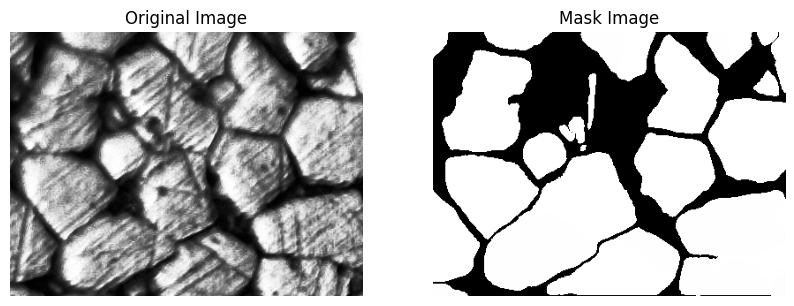

In [ ]:
# Function to display a pair of original and mask images
def mask_pair(img, mask):

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # Display the original crop
    axes[0].imshow(img, cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Original Image')

    # Display the mask crop
    axes[1].imshow(mask, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('Mask Image')

    # Display the plot
    plt.show()

# Display a pair
mask_pair(KAGGLE_original_img, combined_mask)